# Plots for Paper Discussion

## Experimental design

We suspected mutant (DEE/DEE) genes in mice are expressed in retinal angiogenesis.

Given a number of litters, $N$, we look at two animals per litter
- one mutant
- one wild type

** The experiment design indicates a paired (dependent) t-test is to be used.**

Blood vessels were imaged in sections, and some images featured hyaloid vessels.  We selected images without hyaloid vessels to prevent a nuisance parameter.

### Measurables

We looked at the following parameters using AngioTool

- vessels percentage area (vessel density)
- total number of junctions
- total vessels length
- total number of end points

** It's easy to see that # of junctions and vessel lengths are correlated.**

- Cynthia suggests using number of junctions instead of vessel lengths.
    - Scaling this by area to give junction density is a good idea
- Which one is the most important?

**The amount of images per animal is not constant.**
- We average the values obtained from each image
- This does not affect our t-test's sample size
- Is this important enough to show in the paper?

In [1]:
import numpy as np
import pandas as pd

unblinded_file = '../data/unblinded_data.csv'
df = pd.read_csv(unblinded_file)

#df.head() # Look at first five rows

In [2]:
data_mean = (df
             .set_index(['Litter', 'Genotype']) # pivot
             .sort_index(level = ['Litter', 'Genotype'])
             .mean(level = ['Litter', 'Genotype'])
            )

pd.options.display.float_format = '{:,.3f}'.format
#data_mean.head()

In [3]:
wild =   data_mean.xs('+/+',     level = 'Genotype')
mutant = data_mean.xs('DEE/DEE', level = 'Genotype')

data_mean = data_mean.reset_index(0).reset_index()

In [4]:
## Get parameter data arrays
wildVPA =           wild['Vessels percentage area'].values
wildNJunctions =    wild['Total Number of Junctions'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints =    wild['Total Number of End Points'].values

mutantVPA =           mutant['Vessels percentage area'].values
mutantNJunctions =    mutant['Total Number of Junctions'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints =    mutant['Total Number of End Points'].values

In [5]:
from scipy import stats

## Do paired/dependent t-tests
t_VPA, p_VPA = stats.ttest_rel(wildVPA, mutantVPA)

t_n_junct, p_n_junct = stats.ttest_rel(
    wildNJunctions, mutantNJunctions)

t_vessel_length, p_vessel_length = stats.ttest_rel(
    wildVesselsLength, mutantVesselsLength)

t_n_endpoints, p_n_endpoints = stats.ttest_rel(
    wildNEndPoints, mutantNEndPoints)

t_statistics = [t_VPA, t_n_junct, t_vessel_length, t_n_endpoints]
p_values =     [p_VPA, p_n_junct, p_vessel_length, p_n_endpoints]

stat_df = pd.DataFrame({'Parameter': wild.columns,
                        't_statistic': t_statistics, 
                        'p_value': p_values})

stat_df.set_index('Parameter')

,p_value,t_statistic
Parameter,,
Vessels percentage area,0.013,3.761
Total Number of Junctions,0.010,4.007
Total Vessels Length,0.012,3.847
Total Number of End Points,0.795,-0.273


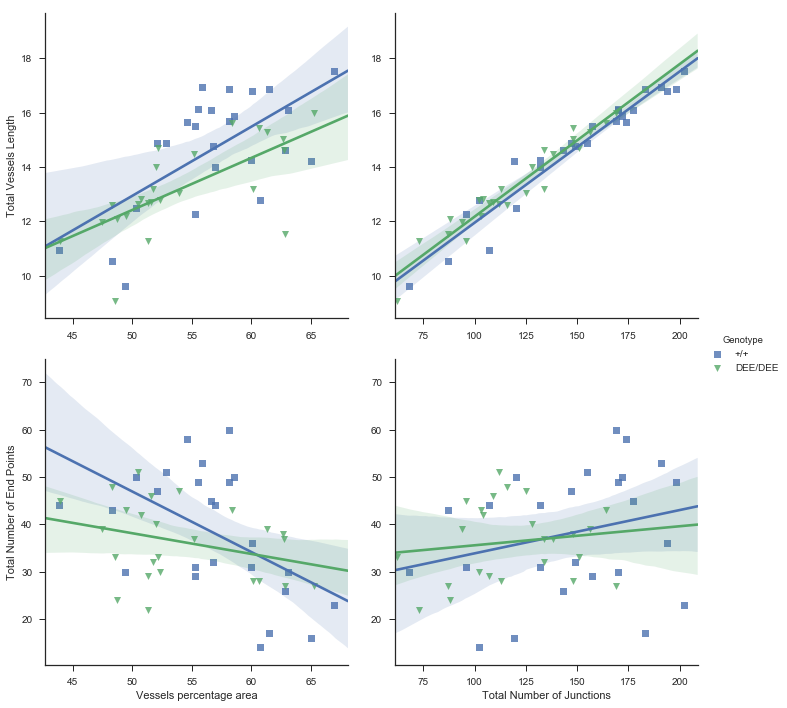

In [59]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns


sns.set(style='ticks', color_codes=True)
#fig1, axes1 = plt.subplots(figsize=(6,6))
sns.pairplot(df,
             hue = 'Genotype',
             hue_order = ['+/+', 'DEE/DEE'],
             x_vars=['Vessels percentage area',
                  'Total Number of Junctions'],
             y_vars=['Total Vessels Length',
                 'Total Number of End Points'],
             markers=['s', 'v'],
             kind='reg',
             size=5,
            )

sns.set(style="white", color_codes=True)
sns.set_context("talk")

## Numbers

### Datatable for difference (Wild - Mutant)

i.e. a positive value here means the mutant was deficient


In [7]:
pd.options.display.float_format = '{:,.2f}'.format

## Look at the difference in means
diff = wild - mutant
diff

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
Litter,,,,
35,6.97,20.67,1.96,-18.00
36,2.15,34.83,1.67,-4.83
37,4.39,11.67,0.44,-2.33
39,6.37,45.00,2.48,6.40
40,4.87,60.60,2.85,12.63
41,-0.12,14.87,0.36,-0.87


If we average across litters, we find the **mean difference** between pairs.

In [8]:
means = diff.mean()
means

Vessels percentage area       4.11
Total Number of Junctions    31.27
Total Vessels Length          1.63
Total Number of End Points   -1.17
dtype: float64

Each parameter's **standard deviation** is seen below

In [9]:
stds = diff.std()
stds

Vessels percentage area       2.67
Total Number of Junctions    19.12
Total Vessels Length          1.04
Total Number of End Points   10.45
dtype: float64

Cohen's $d$, a standardized **effect size**, can be computed by dividing the mean difference by the standard deviation.

In [10]:
means/stds

Vessels percentage area       1.54
Total Number of Junctions     1.64
Total Vessels Length          1.57
Total Number of End Points   -0.11
dtype: float64

### Summary
To summarize our results, we can say something like "On average, retinal blood vessels belonging to mutant mice are 4% less dense than wild type ($d$ = 1.5)"

In [11]:
def pair_dot_plot(befores, afters, ylabel,
                  xticklabels=['+/+', 'mutant DEE/DEE'],
                  ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # plot points
    ax.scatter(np.zeros(len(befores)), befores,
              marker = 's')
    ax.scatter(np.ones(len(afters)), afters,
               marker='v')

    # plot the lines
    for before, after in zip(befores, afters):
        ax.plot( [0,1], [before, after], c='k')

    ax.set_xticks([0,1]) 
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([-0.5, 1.5])
    
    ax.set_ylabel(ylabel)
    
    return None

## Plotting

- dataset?
- results of paired t-test

### Multiple images per animal: to show or not to show?

#### Showing the data
- Pros
    - show that our data satisfy requirements for a t-test
        - limited outliers
        - normality
        - equal variance between litters
    - Good for science
        - Transparent data analysis
        - Reproducibility
    - Shows data as well as their distribution instead of only mean/std
   
   
- Cons 
    - Take up space
    - Litter number doesn't really matter
    - Confuse people?

Many of our litters have as little as three images in them. 

[A box plot should not be used to visualize such a small sample size.](https://www.nature.com/articles/nmeth.2813)

**Categorial scatterplots** to the rescue through `seaborn`'s `stripplot()` and `swarmplot()`.

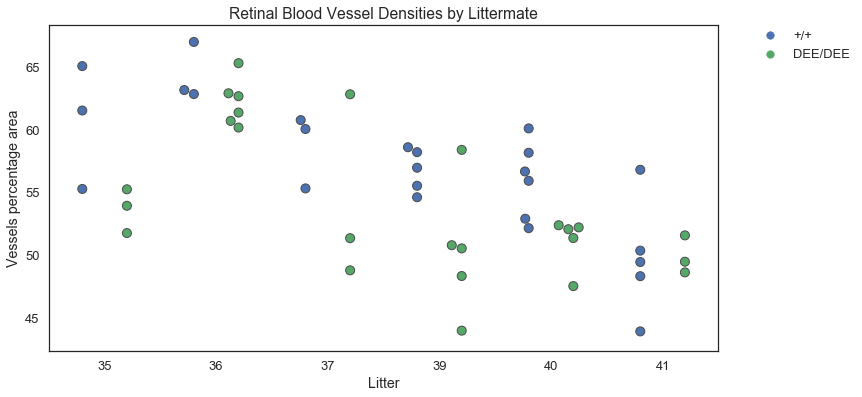

In [12]:
fig, axes = plt.subplots(figsize=(12,6))
sns.swarmplot(x = "Litter",
              y = "Vessels percentage area",
              hue = 'Genotype',
              hue_order = ['+/+', 'DEE/DEE'],
              data = df,
              dodge = True,
              linewidth=1,
              size=9,
              #color = 'k'
             )
plt.title('Retinal Blood Vessel Densities by Littermate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Instead of showing the individual points, we can show the mean and standard deviation via `pointplot()`.

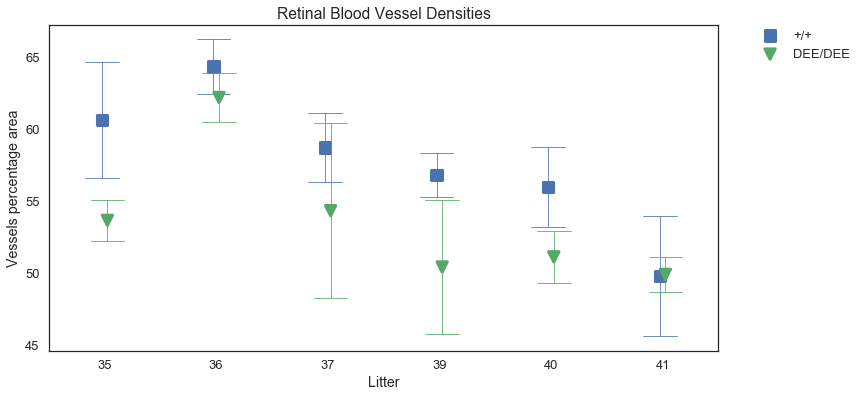

In [13]:
fig, axes = plt.subplots(figsize=(12,6))
sns.pointplot(x = "Litter",
              y = "Vessels percentage area",
              hue = 'Genotype',
              hue_order = ['+/+', 'DEE/DEE'],
              data = df,
              dodge = True,
              ci = 'sd',
              capsize=.3,
              errwidth=.8,
              join=False,
              markers=['s','v']
                       #kind ='box',
                       #size = 4.5,      # figsize
                       #aspect = 1.55, # of figure
                       #width = 0.6,   # of boxes
                       #legend_out = False
                 )

#sns.stripplot(x = "Litter",
#              y = "Vessels percentage area",
#              hue = 'Genotype',
#              hue_order = ['+/+', 'DEE/DEE'],
#              data = df,
#              dodge = True,
              #color = 'k'
#             )
plt.title('Retinal Blood Vessel Densities')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

We can even plot both of the above on the same figure.

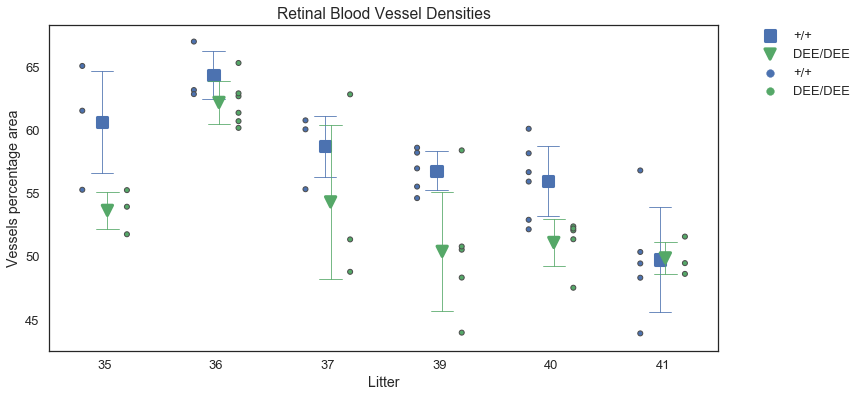

In [14]:
fig, axes = plt.subplots(figsize=(12,6))
sns.pointplot(x = "Litter",
              y = "Vessels percentage area",
              hue = 'Genotype',
              hue_order = ['+/+', 'DEE/DEE'],
              data = df,
              dodge = True,
              ci = 'sd',
              capsize=.2,
              errwidth=.8,
              join=False,
              markers=['s','v']
                       #kind ='box',
                       #size = 4.5,      # figsize
                       #aspect = 1.55, # of figure
                       #width = 0.6,   # of boxes
                       #legend_out = False
                 )

sns.stripplot(x = "Litter",
              y = "Vessels percentage area",
              hue = 'Genotype',
              hue_order = ['+/+', 'DEE/DEE'],
              data = df,
              dodge = True,
              linewidth=1
              #color = 'k'
             )
plt.title('Retinal Blood Vessel Densities')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
#fig, ax = plt.subplots(figsize=(8,5))
#sns.pointplot(x = "Litter",
#              y = "Vessels percentage area",
#              hue ='Genotype',
#              hue_order = ['+/+', 'DEE/DEE'],
#              ci = 'sd',
#              data = df,
#              markers = ["s", "v"],
#              dodge = True,
#              join = False,
#              palette = "Set1"
#             )

The below plot has a very poor data-to-ink ratio.

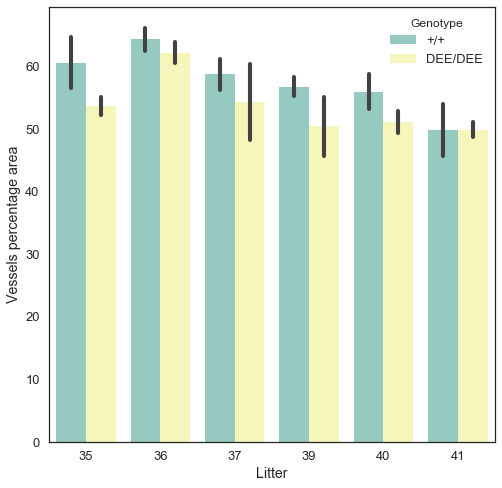

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

### hue_order can be used to only use certain hues

_ = sns.barplot(x = "Litter",
                y = "Vessels percentage area",
                hue = 'Genotype',
                hue_order = ['+/+', 'DEE/DEE'],
                ci = 'sd',
                data = df,
                palette = "Set3"
               )

## Show only the mean value per animal

Pros

- The litter number doesn't show up (not important any way)
- Easy to read, one point per litter.
- **Shows pairing** between groups which reinforces our statistical test
- Possible substitution for summary plot?
- Cynthia suggested it

Cons
- Hides the raw data


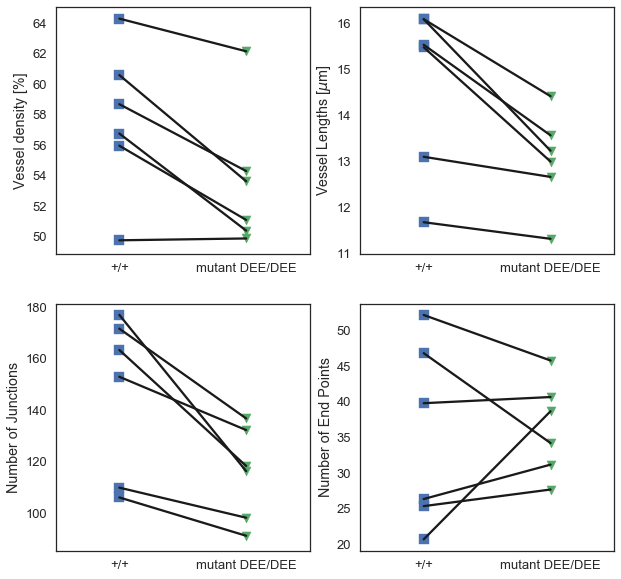

In [17]:
wild_data = [wildVPA, wildVesselsLength,
             wildNJunctions, wildNEndPoints]

mutant_data = [mutantVPA, mutantVesselsLength,
               mutantNJunctions, mutantNEndPoints]

ylabels = ['Vessel density [%]','Vessel Lengths [$\mu$m]',
          'Number of Junctions', 'Number of End Points']

fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()

data_zip = zip(wild_data, mutant_data)

for i, (w, m) in enumerate(data_zip):
    pair_dot_plot(w, m, ylabels[i], ax=ax[i])


## Summarizing statistical test




You've seen a million figures in papers where they show bar graphs like in the first row below. They not wrong, _if you're doing an independent t-test_

**Bar plots are bad (in our case, especially)**
- Our sample size is small (should replace with dot plot)
- bar plots only show means and standard deviations (or standard error) but use lots of space
    - y = 0 is not important in many cases
- Do not visually convey sample size or much information about the distribution

In our case, **showing figures containing the first row would be very misleading.** 


A bar plot that remains true to our statistical paired t-test would simply be one bar that (hopefully) excludes $y=0$. See second row of plots for exampls.

Of course, everything contained in these plots is a mean and standard deviation which means the information can be contained in a simple sentence.

"For vessel density, our mean difference was (4.1 $\pm$2.7)%."

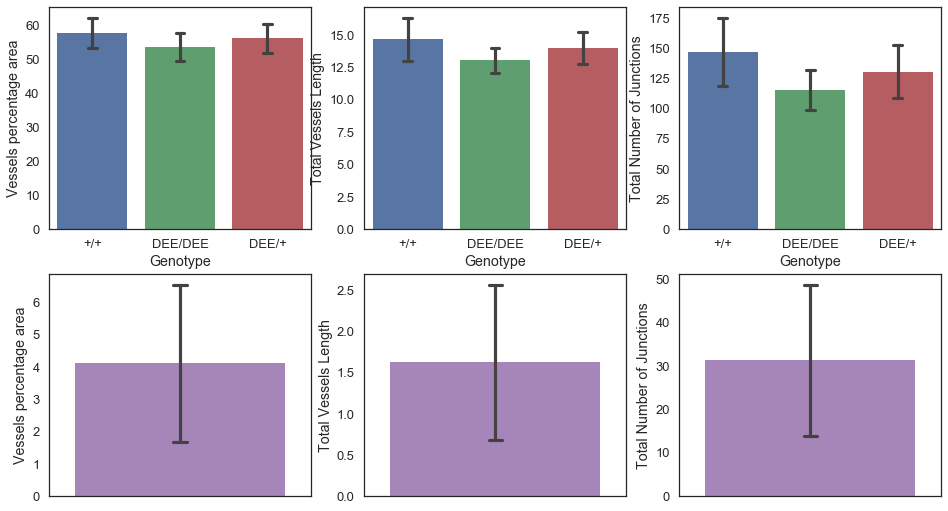

In [18]:
## This is what you would do for an independent t-test
## But we did a dependent t-test
## IMO this should not be shown since it is highly misleading

fig, axes = plt.subplots(nrows= 2, ncols=3, figsize = (16,9))
ax = axes.ravel()

parameters = ['Vessels percentage area', 'Total Vessels Length',
             'Total Number of Junctions']

with sns.plotting_context("notebook", font_scale=1.5):
    for i, parameter in enumerate(parameters): 
        g = sns.factorplot(x = 'Genotype',
                           y = parameter ,
                           #hue_order = ['+/+', 'DEE/DEE'],
                           ci = 'sd',
                           kind = 'bar',
                           capsize = .1,
                           data = data_mean,
                           ax = ax[i]
                          )
        
        _ = sns.barplot(diff[parameter],
                        ci = 'sd',
                        orient ='v',
                        capsize = .05,
                        ax = ax[i+3],
                        color = sns.xkcd_rgb["wisteria"],
                        #alpha=0.9
                       )
        ### factorplot creates its own figure
        ### But we can tell it to plot to a figure
        ### as created outside this loop.
        ### 
        ### If plt.close(g.fig) isn't called,
        ### there will be blank figures.
        plt.close(g.fig)


### Alternative #1

Instead of using a box plot, show the data points themselves! We can include the mean and standard deviation easily enough.

Pros

- True to our analysis
- Arguably the "right" thing to do

Cons
- Not what reviewers/readers are expecting?


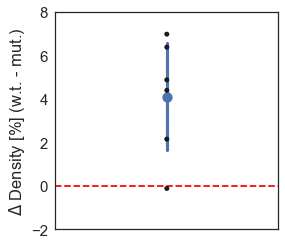

In [19]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(4,4))
    sp = sns.pointplot(y = "Vessels percentage area",
                  data = diff,
                  ci='sd',   
                 )
    _ = sns.stripplot(y = "Vessels percentage area",
                  data = diff,
                  dodge = True,
                  color = 'k'
                 )
    ax.set_ylim([-2,8])
    ax.set_ylabel('$\Delta$ Density [%] (w.t. - mut.)')
    ax.axhline(0, color='red', linestyle='--')
    #plt.title('Difference in retinal blood vessel densities \n between wild type and mutant')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Alternative #2 (Cynthia's suggestion)

We stick with a box plot and normalize to % of wild-type.
Compromise: we also show the points

Pros:
- Familiar to biologists
- Points get shown
- Since it's normalized, they can share the same y-axis

Cons:
- (Potentially) confusing and misleading since this plot isn't related to our statistical test.

In [20]:
normdata = ((mutant / wild.values * 100)
            .rename(
                columns={
                    'Vessels percentage area':'Vessels Density',
                    'Total Number of Junctions':'Number of Junctions',
                    'Total Vessels Length':'Vessels Length',
                    'Total Number of End Points':'Number of End Points'}
                    )
            )

#normdata.drop('Genotype', axis=0, level=1, inplace=True)
#normdata.drop('Vessel Thickness', axis=0, level=1,inplace=True)
normdata = normdata[['Vessels Density','Number of Junctions', 'Vessels Length']]
pd.options.display.float_format = '{:,.2f}'.format
normdata



,Vessels Density,Number of Junctions,Vessels Length
Litter,,,
35,88.49,86.49,87.36
36,96.66,79.71,89.62
37,92.52,89.39,96.67
39,88.77,72.46,83.99
40,91.29,65.76,82.27
41,100.24,86.00,96.92


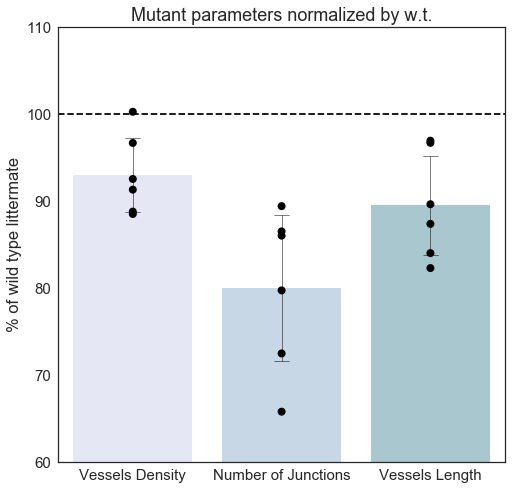

In [21]:
import itertools
#sns.set_style("ticks")
sns.set_style("white")

bar_palette = sns.cubehelix_palette(3, start=0.5,
                                    rot=.9, dark=.75,
                                    light=.9)
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(8,8))
    
    normplot = sns.barplot(data = normdata,
                              ci = 'sd',
                              #kind='bar',
                              #size=8
                           #ax=ax
                           #color='white',
                           palette = bar_palette,
                           errcolor = 'black',
                           errwidth = 0.5,
                           #errcolor = sns.xkcd_rgb['dark teal'],
                           capsize = .1
                          )
    
    sns.stripplot(data = normdata,
                  color=sns.xkcd_rgb["black"],
                  #edgecolor='black',
                  size=8,
                  alpha=1,
                 )
    #sns.stripplot(normdata, ax=ax)
    ax.set_ylabel('% of wild type littermate')
    ax.set_ylim([60,110])
    ax.axhline(100, color='black', linestyle='--')
    ax.set_title('Mutant parameters normalized by w.t.')
    #ax.set_facecolor('w')
    
    ## Bless this man 
    ## https://stackoverflow.com/
    ## questions/42185000/add-hash-pattern-to-a-seaborn-bar-plot
    #num_locations = 1
    #hatches = itertools.cycle(['/', 'x', '\\', '*', 'o', 'O', '.'])
    #for i, bar in enumerate(ax.patches):
    #    if i % num_locations == 0:
    #        hatch = next(hatches)
    #    bar.set_hatch(hatch)

**Let's be part of the statistical revolution in biology!**

## Misc. plots and datatables

Text(0.5,1,'Differences between wild type and mutant')

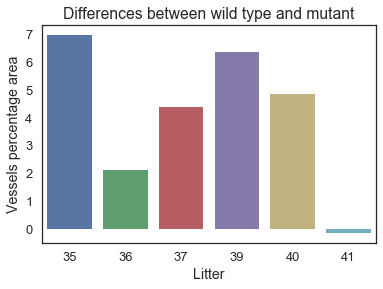

In [22]:
fig, ax = plt.subplots()

_ = sns.barplot(x = diff['Vessels percentage area'].index, 
                y = diff['Vessels percentage area']
               )

ax.set_title('Differences between wild type and mutant')

In [23]:
#fig, ax = plt.subplots(figsize=(8,8))
#sns.violinplot(x = "Litter", y="Vessels percentage area",
#               hue ='Genotype',
#               hue_order = ['+/+', 'DEE/DEE'],
#               data=df,
              #linestyles=["-", "--"],
             #dodge=True
               #split=True,
               #inner='stick'
#             )

In [24]:
#_ = sns.factorplot(x = "Litter",
#                   y = "Vessels percentage area",
#                   hue = 'Genotype',
                   #hue_order = ['+/+', 'DEE/DEE'],
#                   data = df,
#                   ci = 'sd',
#                   dodge = True,
#                   alpha=0.6
#                  )

In [25]:
#sns.factorplot(x = "Litter", y="Vessels percentage area",
#               col = 'Genotype', data=df)

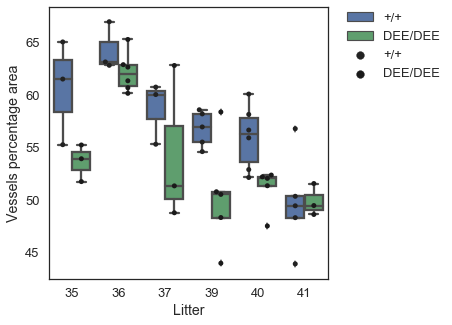

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x = "Litter",
            y = "Vessels percentage area",
            hue = 'Genotype',
            hue_order = ['+/+', 'DEE/DEE'],
            data = df,
              #linestyles=["-", "--"],
             #dodge=True
            #notch=True
            #width=0.25
             )

sns.swarmplot(x = "Litter",
              y = "Vessels percentage area",
              hue = 'Genotype',
              hue_order = ['+/+', 'DEE/DEE'],
              data = df,
              dodge = True,
              color = 'k'
             )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

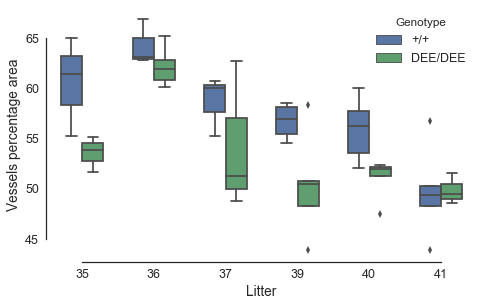

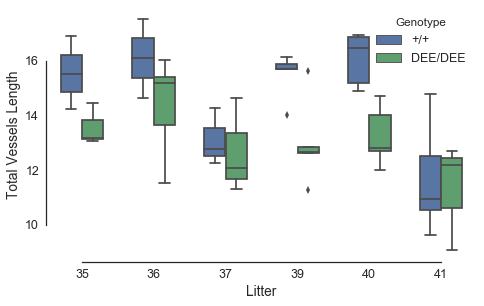

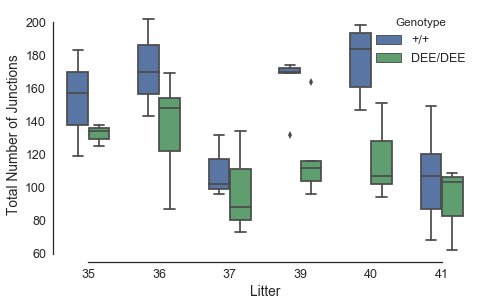

In [27]:
## Box plots of all 

def factorplot_by_litter_and_parameter(parameter_name):
    _ = sns.factorplot(x = "Litter",
                       y = parameter_name,
                       hue = 'Genotype',
                       hue_order = ['+/+', 'DEE/DEE'],
                       data = df,
                       kind ='box',
                       ci = 'sd',
                       size = 4.5,      # figsize
                       aspect = 1.55, # of figure
                       width = 0.6,   # of boxes
                       legend_out = False
                 )
    sns.despine(trim=True)
    


with sns.plotting_context("notebook", font_scale=1.25):
    for parameter in parameters:
        factorplot_by_litter_and_parameter(parameter)

In [28]:
## This is a bad plot because a shared y-axis doesn't make sense
#pd.concat(
#    [diff.mean().rename('diff')],
#    axis=1
#).plot.bar()
#plt.show()

## Mean and std for different variables in different litters

If you want to look at the numbers after averaging, here they are.

In [29]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe()
)

count  mean   std   min   25%   50%   75%   max
Litter Genotype                                                 
35     +/+        3.00 20.67  7.23 16.00 16.50 17.00 23.00 29.00
       DEE/DEE    3.00 38.67  7.64 32.00 34.50 37.00 42.00 47.00
36     +/+        3.00 26.33  3.51 23.00 24.50 26.00 28.00 30.00
       DEE/DEE    6.00 31.17  5.71 27.00 27.25 28.00 35.50 39.00
37     +/+        3.00 25.33  9.81 14.00 22.50 31.00 31.00 31.00
       DEE/+      2.00 32.50 12.02 24.00 28.25 32.50 36.75 41.00
       DEE/DEE    3.00 27.67  8.14 22.00 23.00 24.00 30.50 37.00
39     +/+        5.00 52.20  6.65 44.00 49.00 50.00 58.00 60.00
       DEE/+      6.00 36.50  9.22 26.00 33.00 33.50 38.50 53.00
       DEE/DEE    5.00 45.80  3.70 42.00 43.00 45.00 48.00 51.00
40     +/+        6.00 46.83  6.01 36.00 45.50 48.00 50.50 53.00
       DEE/+      4.00 32.25  6.08 25.00 28.75 32.50 36.00 39.00
       DEE/DEE    5.00 34.20  5.07 29.00 30.00 33.00 39.00 40.00
41     +/+        5.00 39.80  8.50 30.00 32.00 43.00 44.00 50.00
       DEE/DEE    3.00 40.67  6.81 33.00 38.00 43.00 44.50 46.00

In [30]:
(df.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 60.59 4.96 55.25 58.37 61.50 63.27 65.03
       DEE/DEE    3.00 53.62 1.76 51.73 52.82 53.91 54.56 55.22
36     +/+        3.00 64.30 2.31 62.81 62.97 63.13 65.04 66.96
       DEE/DEE    6.00 62.15 1.86 60.14 60.84 61.98 62.81 65.27
37     +/+        3.00 58.68 2.96 55.29 57.66 60.02 60.38 60.73
       DEE/+      2.00 61.73 5.38 57.92 59.83 61.73 63.63 65.54
       DEE/DEE    3.00 54.29 7.47 48.76 50.04 51.32 57.06 62.79
39     +/+        5.00 56.75 1.71 54.59 55.50 56.94 58.18 58.57
       DEE/+      6.00 55.09 2.05 52.11 54.29 54.79 56.14 58.11
       DEE/DEE    5.00 50.38 5.23 43.96 48.31 50.51 50.76 58.36
40     +/+        6.00 55.96 3.04 52.12 53.63 56.27 57.76 60.07
       DEE/+      4.00 51.47 3.82 46.53 49.46 52.22 54.23 54.94
       DEE/DEE    5.00 51.08 2.04 47.50 51.34 52.04 52.19 52.35
41     +/+        5.00 49.74 4.64 43.90 48.30 49.42 50.33 56.77
       DEE/DEE    3.00 49.87 1.52 48.60 49.02 49.45 50.50 51.55

In [31]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Number of Junctions']
                     .describe()
)

count   mean   std    min    25%    50%    75%    max
Litter Genotype                                                       
35     +/+        3.00 153.00 32.19 119.00 138.00 157.00 170.00 183.00
       DEE/DEE    3.00 132.33  6.66 125.00 129.50 134.00 136.00 138.00
36     +/+        3.00 171.67 29.54 143.00 156.50 170.00 186.00 202.00
       DEE/DEE    6.00 136.83 30.67  87.00 121.75 148.00 154.00 169.00
37     +/+        3.00 110.00 19.29  96.00  99.00 102.00 117.00 132.00
       DEE/+      2.00 161.00  2.83 159.00 160.00 161.00 162.00 163.00
       DEE/DEE    3.00  98.33 31.79  73.00  80.50  88.00 111.00 134.00
39     +/+        5.00 163.40 17.66 132.00 169.00 170.00 172.00 174.00
       DEE/+      6.00 119.67 11.99 107.00 111.25 118.50 123.50 140.00
       DEE/DEE    5.00 118.40 26.62  96.00 104.00 112.00 116.00 164.00
40     +/+        6.00 177.00 21.49 147.00 160.50 184.00 193.25 198.00
       DEE/+      4.00 111.25 14.93 101.00 101.75 105.50 115.00 133.00
       DEE/DEE    5.00 116.40 23.07  94.00 102.00 107.00 128.00 151.00
41     +/+        5.00 106.20 31.03  68.00  87.00 107.00 120.00 149.00
       DEE/DEE    3.00  91.33 25.58  62.00  82.50 103.00 106.00 109.00

In [32]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 15.53 1.33 14.21 14.86 15.50 16.19 16.88
       DEE/DEE    3.00 13.57 0.78 13.05 13.12 13.18 13.82 14.47
36     +/+        3.00 16.09 1.44 14.64 15.37 16.09 16.81 17.52
       DEE/DEE    6.00 14.42 1.71 11.54 13.64 15.17 15.40 16.01
37     +/+        3.00 13.10 1.05 12.26 12.52 12.77 13.52 14.28
       DEE/+      2.00 15.67 0.02 15.66 15.67 15.67 15.68 15.69
       DEE/DEE    3.00 12.67 1.74 11.29 11.69 12.08 13.35 14.62
39     +/+        5.00 15.48 0.85 14.00 15.68 15.68 15.88 16.14
       DEE/+      6.00 13.48 0.90 12.36 13.01 13.52 13.59 15.02
       DEE/DEE    5.00 13.00 1.59 11.27 12.61 12.66 12.84 15.62
40     +/+        6.00 16.09 0.98 14.88 15.20 16.46 16.86 16.95
       DEE/+      4.00 12.85 1.03 11.96 12.10 12.61 13.36 14.21
       DEE/DEE    5.00 13.23 1.09 11.99 12.70 12.79 14.01 14.69
41     +/+        5.00 11.68 2.02  9.64 10.55 10.94 12.50 14.79
       DEE/DEE    3.00 11.32 1.96  9.08 10.63 12.18 12.45 12.71